# Multiclass Classification with Convolutional Neural Networks
Version 1.0

(C) 2020 - Umberto Michelucci, Michela Sperti

This notebook is part of the book _Applied Deep Learning: a case based approach, **2nd edition**_ from APRESS by [U. Michelucci](mailto:umberto.michelucci@toelt.ai) and [M. Sperti](mailto:michela.sperti@toelt.ai).

The purpose of this notebook is to give a practical example (with a dataset taken from the real world) of a multiclass classification problem solved by means of a Convolutional Neural Network (CNN) architecture. It may be instructive to compare the results of this notebook with the ones of *Multiclass_classification_with_fully_connected_networks.ipynb* notebook, which solves the same problem, but with a simpler architecture.

## Notebook Learning Goals

At the end of the notebook you are going to know how to implement yourself a CNN architecture in Keras. Moreover, you will be able to to apply it to other image recognition problems.

## Dataset Overview

**Context**

Fashion-MNIST is a dataset of Zalando's article images (consisting of a training set of 60000 examples and a test set of 10000 examples). Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."
Zalando seeks to replace the original MNIST dataset

**Content**


Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed $x$ as $x = 28i + j$, where $i$ and $j$ are integers between 0 and 27. The pixel is located on row $i$ and column $j$ of a 28x28 matrix.
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top.

Each row of the dataset is a separate image. Column 1 is the class label.
Remaining columns are pixel numbers (784 total). Each value is the darkness of the pixel (1 to 255).

**Labels**

Each training and test example is assigned to one of the following labels:
- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

**Acknowledgements**

Original dataset was downloaded from TensorFlow datasets catalog.

**License**

The MIT License (MIT) Copyright © [2017] Zalando SE, https://tech.zalando.com

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Libraries and Dataset Import

This section contains the necessary libraries (such as tensorflow or pandas) you need to import to run the notebook.

In [1]:
# general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# tensorflow libraries
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras import layers, models

The following cells are needed to **download** the dataset.

In [2]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**Let's have a look at our data**:

In [3]:
print('Dimensions of the training dataset: ', trainX.shape)
print('Dimensions of the test dataset: ', testX.shape)
print('Dimensions of the training labels: ', trainY.shape)
print('Dimensions of the test labels: ', testY.shape)

Dimensions of the training dataset:  (60000, 28, 28)
Dimensions of the test dataset:  (10000, 28, 28)
Dimensions of the training labels:  (60000,)
Dimensions of the test labels:  (10000,)


## Dataset Preparation

We now one-hot encode the labels and change the images dimensions, to get easy to use data for later. To know more about one-hot encoding process see the [Further Readings](#fr) section or refer to the hands-on chapter of the book about feed-forward neural networks.

In [4]:
labels_train = np.zeros((60000, 10))
labels_train[np.arange(60000), trainY] = 1

data_train = trainX.reshape(60000, 28, 28, 1)

In [5]:
labels_test = np.zeros((10000, 10))
labels_test[np.arange(10000), testY] = 1

data_test = testX.reshape(10000, 28, 28, 1)

In [6]:
print('Dimensions of the training dataset: ', data_train.shape)
print('Dimensions of the test dataset: ', data_test.shape)
print('Dimensions of the training labels: ', labels_train.shape)
print('Dimensions of the test labels: ', labels_test.shape)

Dimensions of the training dataset:  (60000, 28, 28, 1)
Dimensions of the test dataset:  (10000, 28, 28, 1)
Dimensions of the training labels:  (60000, 10)
Dimensions of the test labels:  (10000, 10)


## Data Inspection

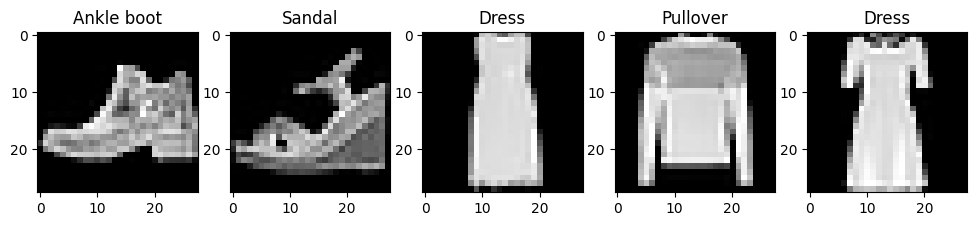

In [7]:
plt.figure(figsize=(12, 3))
rand_ids = np.random.permutation(len(data_train))[:5]
for i, rand_id in enumerate(rand_ids):
  plt.subplot(1, len(rand_ids), i+1)
  plt.title(labels[trainY[rand_id]])
  plt.imshow(data_train[rand_id], cmap='gray')

plt.show()

## Data Normalization

Let's normalize the training data dividing by 255.0 to get the values between 0 and 1.

In [8]:
data_train_norm = np.array(data_train/255.0)
data_test_norm = np.array(data_test/255.0)

## Convolutional Neural Network Model

Let us try to build one such a network to give you a feeling of how the process would work and how the code looks like. We will not do any hyperparameter tuning or optimization to keep the section understandable.

Our CNN will be made of the following layers:
- **CONV1**: 6 filters 5 x 5, stride $s=1$
- We then apply **ReLU** to the output of the previous layer
- **POOL1** with a window 2 × 2, stride $s=2$
- **CONV2**: 16 Filters 5 × 5, stride $s=1$
- We then apply **ReLU** to the output of the previous layer
- **POOL2** with a window 2 × 2, stride $s=2$
- **Fully Connected Layer** with 128 neurons with activation function ReLU
- **Fully Connected Layer** with 10 neurons for classification of the Zalando dataset
- **Softmax** output neuron

Softmax function here is needed since we one-hot encoded the labels. To have more details about this, see the [Further Readings](#fr) section of the notebook or refer to the hands-on chapter of the book about feed-forward neural networks.


In [9]:
def build_model():
  # create model
  model = models.Sequential()
  model.add(layers.Conv2D(6, (5, 5), strides = (1, 1), activation = 'relu', input_shape = (28, 28, 1)))
  model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
  model.add(layers.Conv2D(16, (5, 5), strides = (1, 1), activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation = 'relu'))
  model.add(layers.Dense(10, activation = 'softmax'))
  # compile model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])
  return model

In [10]:
model = build_model()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               3

We now train the model.

In [12]:
EPOCHS = 10

history = model.fit(
  data_train_norm, labels_train,
  epochs = EPOCHS, verbose = 1,
  batch_size = 100)

Epoch 1/10
600/600 [==============================] - 31s 48ms/step - loss: 0.6333 - categorical_accuracy: 0.7742
Epoch 2/10
600/600 [==============================] - 23s 39ms/step - loss: 0.4166 - categorical_accuracy: 0.8500
Epoch 3/10
600/600 [==============================] - 23s 39ms/step - loss: 0.3673 - categorical_accuracy: 0.8684
Epoch 4/10
600/600 [==============================] - 22s 37ms/step - loss: 0.3384 - categorical_accuracy: 0.8781
Epoch 5/10
600/600 [==============================] - 24s 39ms/step - loss: 0.3182 - categorical_accuracy: 0.8863
Epoch 6/10
600/600 [==============================] - 24s 40ms/step - loss: 0.3021 - categorical_accuracy: 0.8910
Epoch 7/10
600/600 [==============================] - 23s 39ms/step - loss: 0.2873 - categorical_accuracy: 0.8955
Epoch 8/10
600/600 [==============================] - 23s 39ms/step - loss: 0.2757 - categorical_accuracy: 0.9009
Epoch 9/10
600/600 [==============================] - 22s 37ms/step - loss: 0.2651 - cat

And we used the trained model on the test dataset.

In [13]:
test_loss, test_accuracy = model.evaluate(data_test_norm, labels_test, verbose = 0)
print('The accuracy on the test set is equal to: ', int(test_accuracy*100), '%.')

The accuracy on the test set is equal to:  88 %.


1/1 [==============================] - 0s 33ms/step


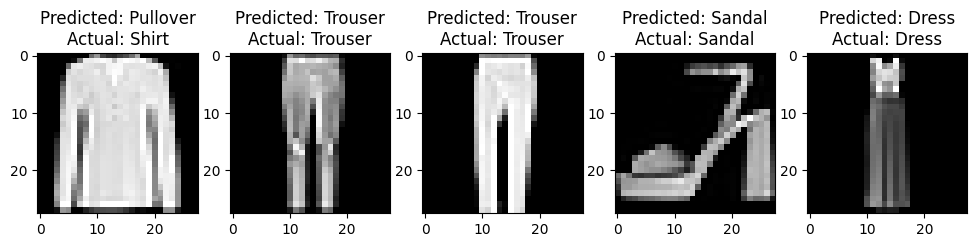

In [14]:
np.random.seed(1)
rand_ids = np.random.permutation(len(data_test))[:5]

plt.figure(figsize=(12, 3))
for i, rand_id in enumerate(rand_ids):
  actual_label = labels[testY[rand_id]]
  predicted_label = np.expand_dims(data_test_norm[rand_id], axis=0)
  predicted_label = labels[np.argmax(model.predict(predicted_label))]

  plt.subplot(1, len(rand_ids), i+1)
  plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}")
  plt.imshow(data_test[rand_id], cmap='gray')

plt.show()

## How robust is the CNN?

Pick an image that gets correctly classified by the CNN, then try to change the image such that it gets misclassified.

1/1 [==============================] - 0s 31ms/step


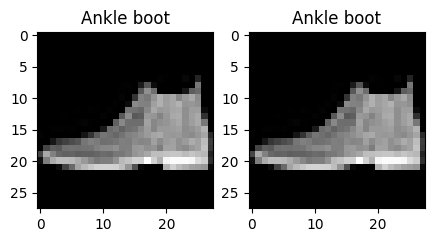

In [15]:
def corrupt_image(image):
  # FILL IN HERE
  return image

sample_id = 0
actual_label = labels[testY[sample_id]]

# Predict label for sample image
sample_image = data_test_norm[sample_id]
predicted_label = np.expand_dims(sample_image, axis=0)
predicted_label = labels[np.argmax(model.predict(predicted_label))]
assert predicted_label == actual_label, "Pick a sample that is correctly classified"

# Predict label for corrupted image
corrupted_image = corrupt_image(sample_image)
corrupted_label = np.expand_dims(corrupted_image, axis=0)
corrupted_label = labels[np.argmax(model.predict(corrupted_label))]

plt.figure(figsize=(5, 3))

plt.subplot(1, 2, 1)
plt.title(predicted_label)
plt.imshow(sample_image, cmap='gray', vmin=0, vmax=1)

plt.subplot(1, 2, 2)
plt.title(corrupted_label)
plt.imshow(corrupted_image, cmap='gray', vmin=0, vmax=1)
plt.show()

## What Filters were learned?

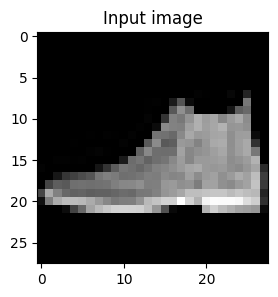

1/1 [==============================] - 0s 71ms/step


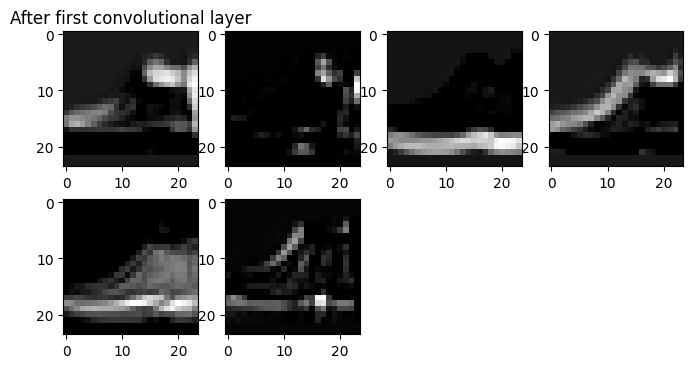

1/1 [==============================] - 0s 56ms/step


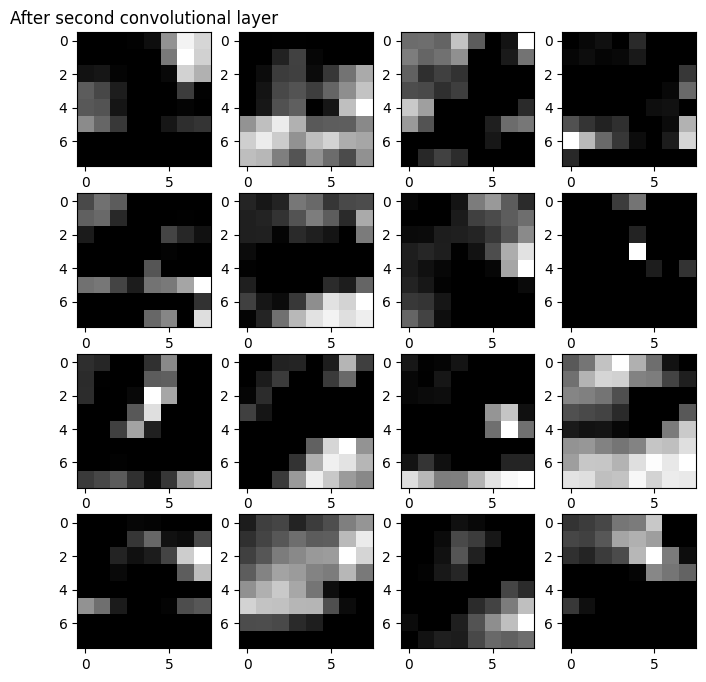

In [16]:
sample_image = data_test_norm[0]

plt.figure(figsize=(3, 3))
plt.title('Input image')
plt.imshow(sample_image, cmap='gray', vmin=0, vmax=1)
plt.show()

model_up_to_first_conv = models.Sequential(model.layers[:1])
model_up_to_second_conv = models.Sequential(model.layers[:3])

for title, submodel in [('After first convolutional layer', model_up_to_first_conv),
                        ('After second convolutional layer', model_up_to_second_conv)]:
  features = submodel.predict(np.expand_dims(sample_image, axis=0))[0]
  features = np.split(features, features.shape[2], axis=2)

  n_cols = 4
  n_rows = int(np.ceil(len(features) / n_cols))
  plt.figure(figsize=(8, n_rows * 2))
  for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(feature, cmap='gray')
    if i == 0: plt.title(title)

  plt.show()

## Exercises

1. [*Easy Difficulty*] Try to build a multiclass classification model like the one we saw together in this notebook, but with a different dataset, the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/). To download the dataset from TensorFlow use the following lines of code:
```
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
```
2. [*Medium Difficulty*] Try to change the network's parameters to see if you can get a higher accuracy. Change kernel size, stride, and padding.

## Further Readings

**Fashion-MNIST dataset**

1. Xiao, Han, Kashif Rasul, and Roland Vollgraf. "Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms." arXiv preprint arXiv:1708.07747 (2017)

**One-hot encoding, integer encoding, softmax function**

1. https://deepai.org/machine-learning-glossary-and-terms/one-hot-encoding (what one-hot encoding means)
2. https://towardsdatascience.com/softmax-activation-function-how-it-actually-works-d292d335bd78 (why we need to use softmax function and the difference between one-hot encoding and integer encoding)